### Importación de librerías

In [3]:
#pip install datasets netron

In [42]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms, models, utils
from PIL import Image
from datasets import load_dataset
from datasets import Dataset as dset
import math
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
import netron
import timm

### Cargar el DataSet

#### Funciones

In [43]:
# =============================
# Función de Mapeo de etiquetas
# =============================

# (0,1) -> 0 (COVID)
# (2,3) -> 1 (Lung Opacity)
# (4,5) -> 2 (Normal)

def map_labels(label):
    if label in {0, 1}:
        return 0
    elif label in {2, 3}:
        return 1
    elif label in {4, 5}:
        return 2
    else:
        raise ValueError(f"Etiqueta inesperada: {label}")


In [48]:
# =================================
# Definir una clase para el Dataset
# =================================

class CovidDataset(Dataset):

    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        if not isinstance(image, Image.Image):
            image = Image.open(image).convert("RGB")
        else:
            image = image.convert("RGB")

        # Mapeamos la etiqueta
        label = map_labels(sample['label'])

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.dataset)

#### Dataset

In [49]:
# ======================================================
# Definimos las las transformaciones [Data Augmentation]
# ======================================================

# Data Augmentation Mejorado
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [50]:
# ======================================
# Se carga el dataset desde Hugging Face
# ======================================

streaming_dataset = load_dataset("Flooki10/autotrain-data-pr_final_covid-19", streaming=True)
print(streaming_dataset)

Resolving data files:   0%|          | 0/401 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/198 [00:00<?, ?it/s]

IterableDatasetDict({
    train: IterableDataset({
        features: ['image', 'label'],
        num_shards: 399
    })
    validation: IterableDataset({
        features: ['image', 'label'],
        num_shards: 99
    })
    test: IterableDataset({
        features: ['image', 'label'],
        num_shards: 198
    })
})


In [51]:

train_dataset_raw = dset.from_list(list(streaming_dataset['train']))
val_dataset_raw   = dset.from_list(list(streaming_dataset['test']))


# =================================================================
# Se crean instancias del dataset y se aplican las transformaciones
# =================================================================

train_dataset = CovidDataset(train_dataset_raw, transform=train_transform)
val_dataset   = CovidDataset(val_dataset_raw,   transform=val_transform)

# ========================
# Se crean los DataLoaders
# ========================

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

### Exploración del Dataset

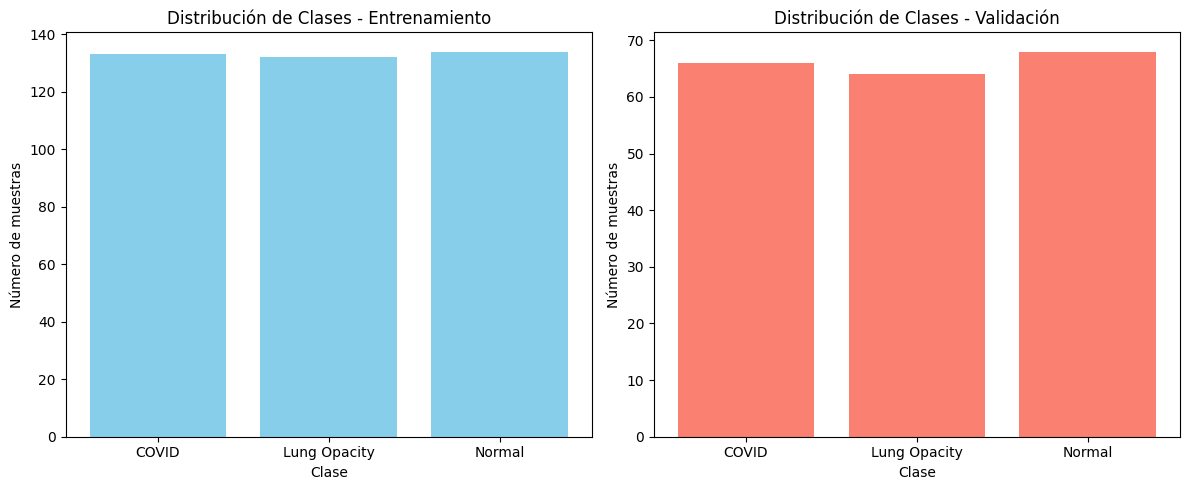

In [52]:
# ============================================================
# Se verifica el balance de clases dentro del conjuto de datos
# ============================================================

# Data de Entrenamiento

train_labels_mapped = [map_labels(sample['label']) for sample in train_dataset_raw]
train_counts = Counter(train_labels_mapped)

# Data de Test
val_labels_mapped = [map_labels(sample['label']) for sample in val_dataset_raw]
val_counts = Counter(val_labels_mapped)

# Se establecen las clases
classes = ['COVID', 'Lung Opacity', 'Normal']

plt.figure(figsize=(12, 5))

# Gráfico de barras para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.bar(classes, [train_counts[i] for i in range(len(classes))], color='skyblue')
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.title("Distribución de Clases - Entrenamiento")

# Gráfico de barras para el conjunto de validación
plt.subplot(1, 2, 2)
plt.bar(classes, [val_counts[i] for i in range(len(classes))], color='salmon')
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.title("Distribución de Clases - Validación")

plt.tight_layout()
plt.show()


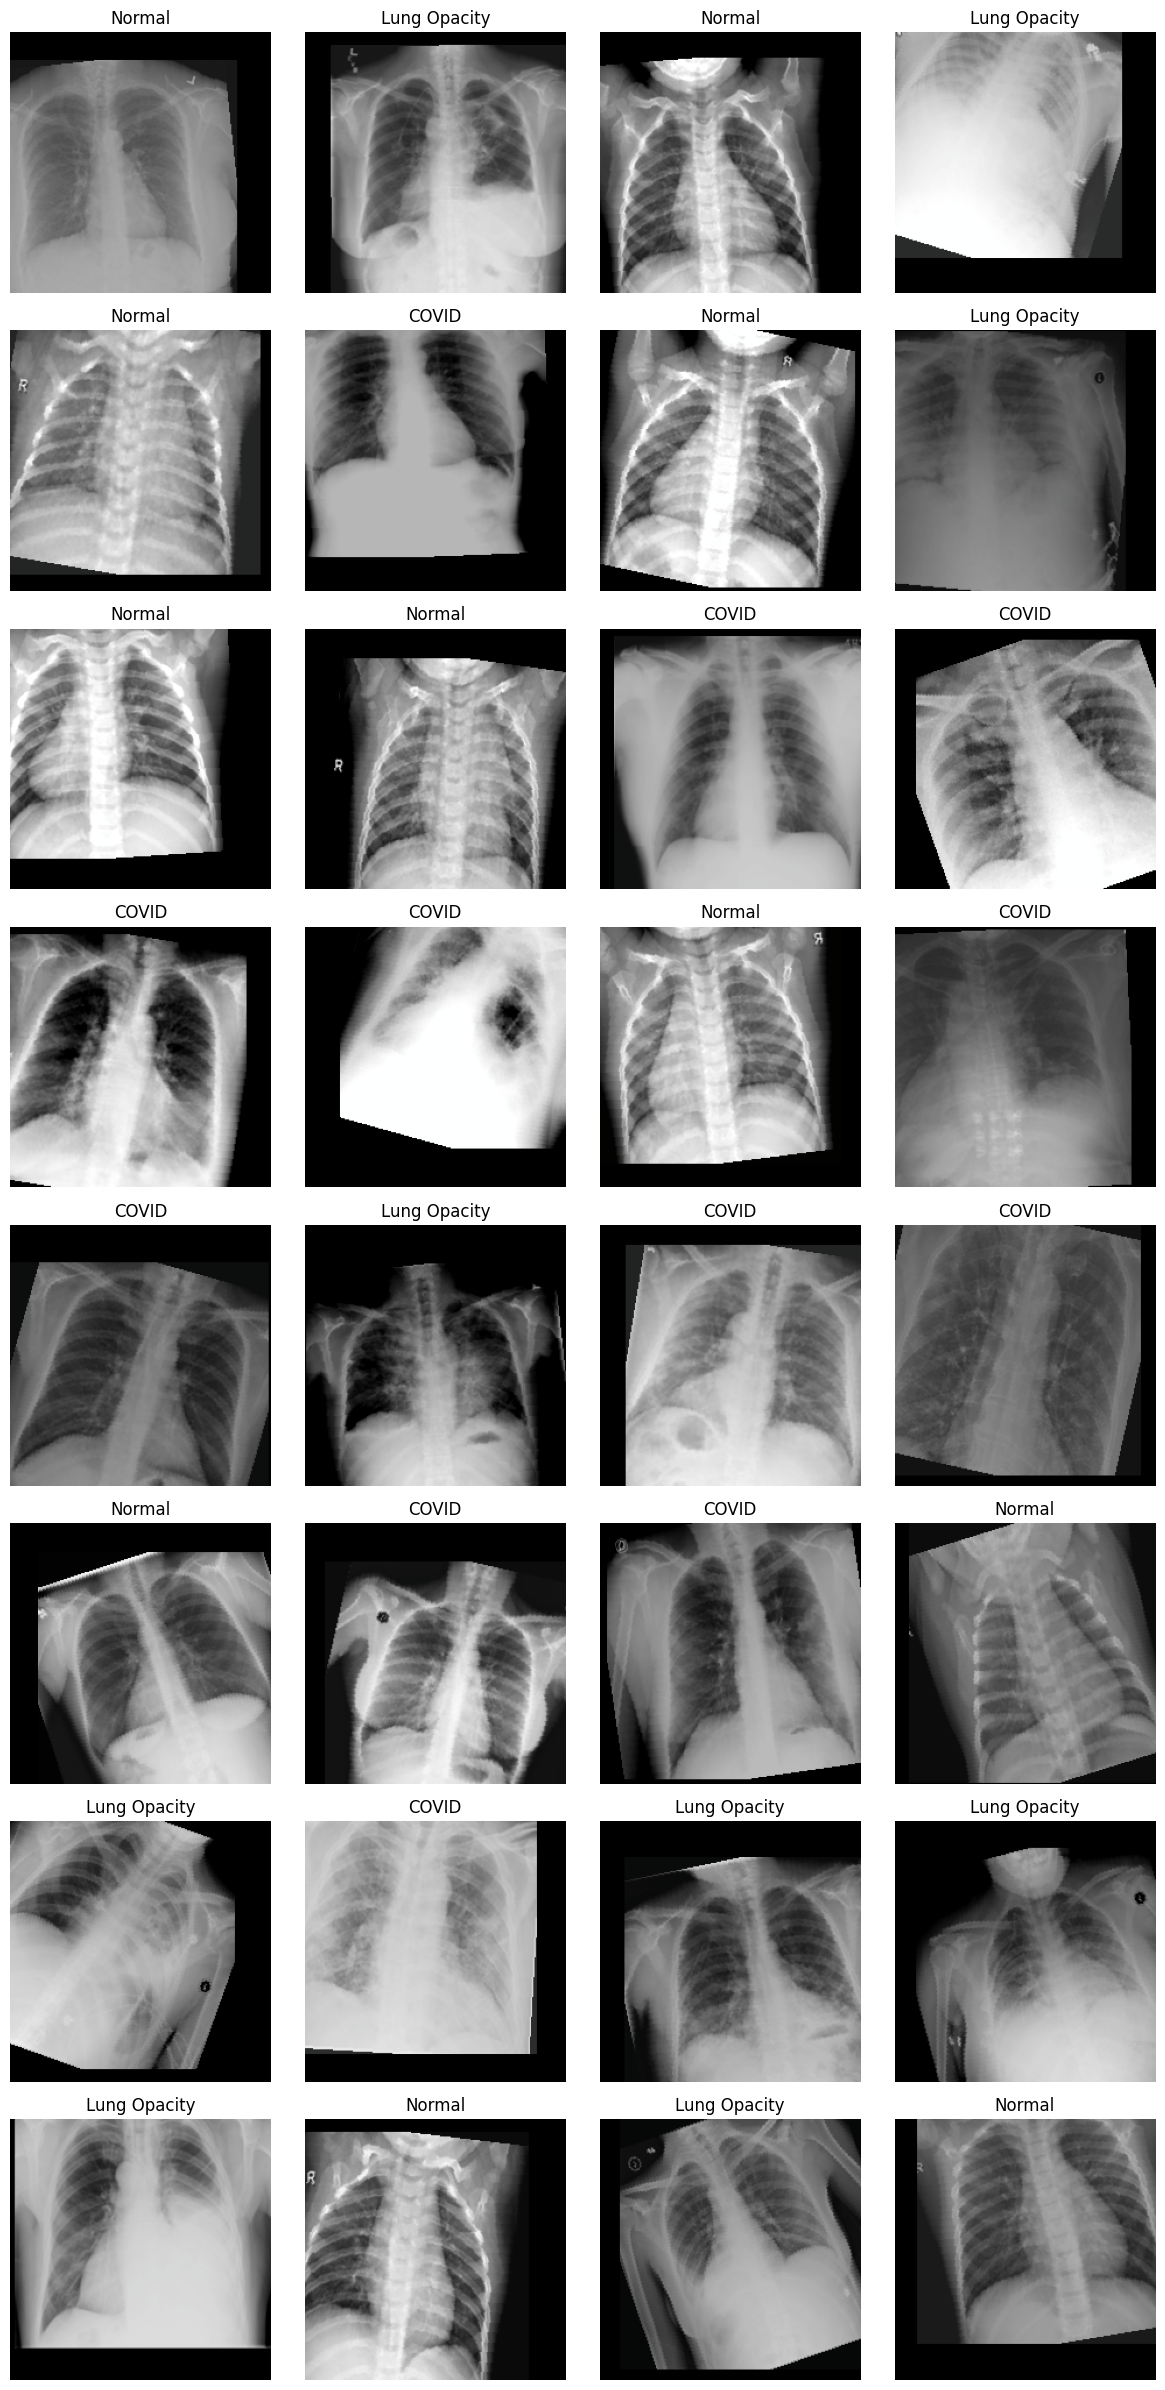

In [53]:
# =====================================================
# Se grafican algunas imagenes del Dataset con su clase
# =====================================================

# El listado de las imagenes
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Las clases de las imagenes
classes = ['COVID', 'Lung Opacity', 'Normal']

# Cantidad de Imagenes
num_images = len(images)

# Columnas y Filas
cols = 4
rows = math.ceil(num_images/cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

for idx, (img, lbl) in enumerate(zip(images, labels)):
    img_np = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    axes[idx].imshow(img_np)
    axes[idx].set_title(classes[lbl])
    axes[idx].axis('off')

for ax in axes[idx+1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


### Transfer Learning

#### Se carga el modelo EfficientNet V2 S

In [54]:
# Seleccionar el dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [55]:
# Cargar el modelo preentrenado
model = timm.create_model('xception', pretrained=True)
model.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [56]:
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.7),  # Aumentamos el Dropout a 0.7
    nn.Linear(num_features, 3)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)  # Mayor weight decay

# Scheduler con reducción agresiva del LR
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True)

#### Funciones de entrenamiento y validación

In [57]:
# Función de Entrenamiento
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    batch_idx = 0

    for inputs, labels in dataloader:
        batch_idx += 1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}: loss = {loss.item():.4f}")

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [58]:
# Función de Validación
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [59]:
class EarlyStopping:
    def __init__(self, patience=7):  # Aumentamos paciencia para permitir más aprendizaje
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model_wts = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

#### Se entrena el nuevo modelo

In [60]:
# Verificamos que el modelo este en la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo usado:", device)
print("Modelo en:", next(model.parameters()).device)

Dispositivo usado: cuda
Modelo en: cuda:0


In [62]:
num_epochs = 30  # Aumentamos para permitir convergencia con Early Stopping
best_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []
early_stopping = EarlyStopping(patience=7)  # Aumentamos paciencia

print("Época | Train Loss | Train Acc | Val Loss | Val Acc")
print("------------------------------------------------------")
for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    t_loss = running_loss / len(train_loader.dataset)
    t_acc = running_corrects.double() / len(train_loader.dataset)

    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    v_loss = running_loss / len(val_loader.dataset)
    v_acc = running_corrects.double() / len(val_loader.dataset)

    scheduler.step(v_loss)
    train_losses.append(t_loss)
    train_accs.append(t_acc.item())
    val_losses.append(v_loss)
    val_accs.append(v_acc.item())

    print(f"{epoch+1:5d} | {t_loss:10.4f} | {t_acc:9.4f} | {v_loss:8.4f} | {v_acc:7.4f}")

    if v_acc > best_acc:
        best_acc = v_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), f"/content/xception_models/xception_best_model_tl_epoch_{epoch+1}_3ra_intent.pth")
        print(f"Modelo guardado: /content/xception_models/xception_best_model_tl_epoch_{epoch+1}_3ra_intent.pth")

    if early_stopping.step(v_loss, model):
        print("Early stopping activado. Terminando entrenamiento.")
        break

print("------------------------------------------------------")
print("Mejor precisión en validación: {:.4f}".format(best_acc))
model.load_state_dict(best_model_wts)

Época | Train Loss | Train Acc | Val Loss | Val Acc
------------------------------------------------------
    1 |     0.6326 |    0.7569 |   1.3078 |  0.4444
Modelo guardado: /content/xception_models/xception_best_model_tl_epoch_1_3ra_intent.pth
    2 |     0.3889 |    0.8596 |   0.5801 |  0.7879
Modelo guardado: /content/xception_models/xception_best_model_tl_epoch_2_3ra_intent.pth
    3 |     0.3885 |    0.8622 |   0.7083 |  0.7273
    4 |     0.2525 |    0.9173 |   0.6192 |  0.7374
    5 |     0.2281 |    0.9173 |   0.4501 |  0.8586
Modelo guardado: /content/xception_models/xception_best_model_tl_epoch_5_3ra_intent.pth
    6 |     0.2053 |    0.9198 |   0.5249 |  0.8283
    7 |     0.2424 |    0.9073 |   0.3991 |  0.8586
    8 |     0.1904 |    0.9273 |   0.7479 |  0.8182
    9 |     0.2484 |    0.8997 |   0.4885 |  0.8889
Modelo guardado: /content/xception_models/xception_best_model_tl_epoch_9_3ra_intent.pth
   10 |     0.1942 |    0.9198 |   0.5768 |  0.7778
   11 |     0.1465 | 

<All keys matched successfully>

#### Métricas del nuevo modelo

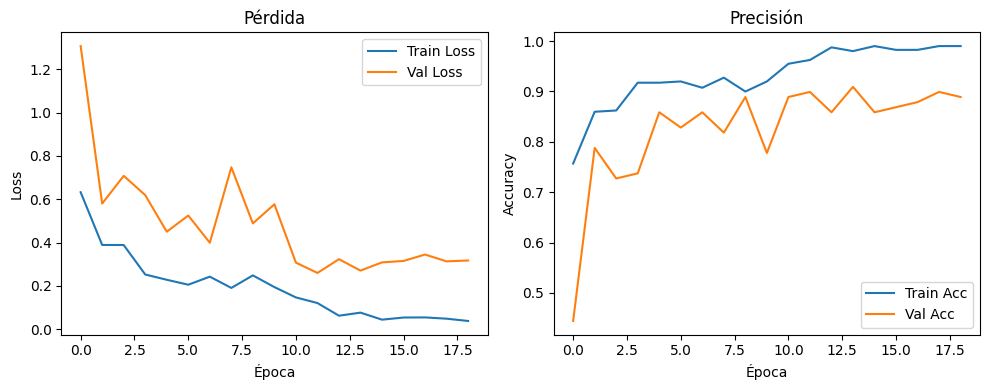

In [63]:
# =======================
# Curvas de Entrenamiento
# =======================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Precisión")
plt.legend()

plt.tight_layout()
plt.show()

Reporte de clasificación:
              precision    recall  f1-score   support

       COVID       0.97      0.94      0.95        66
Lung Opacity       0.84      0.97      0.90        64
      Normal       0.93      0.82      0.88        68

    accuracy                           0.91       198
   macro avg       0.91      0.91      0.91       198
weighted avg       0.91      0.91      0.91       198



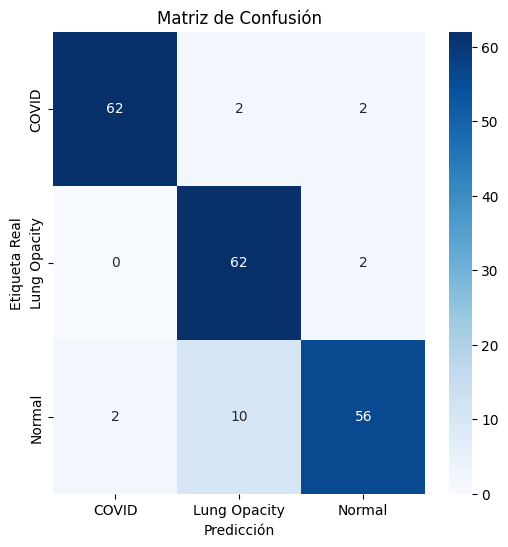

In [64]:
# ===================
# Matriz de Confusión
# ===================

# Inicializamos listas para almacenar predicciones y etiquetas reales
all_preds = []
all_labels = []

# Evaluar el modelo en el conjunto de validación
model.eval()  # Modo evaluación

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print("Reporte de clasificación:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()


#### Se guarda el nuevo modelo en PTH y TorchScript

In [ ]:
# Guardar el state_dict del modelo en un archivo .pth
torch.save(model.state_dict(), "modelo_covid19.pth")
print("Modelo guardado en 'modelo_covid19.pth'")

Modelo guardado en 'modelo_covid19.pth'


In [ ]:
# Convertir el modelo a TorchScript
scripted_model = torch.jit.script(model)

# Guardar el modelo en un archivo .pt
torch.jit.save(scripted_model, "modelo_scripted.pt")
print("Modelo exportado a 'modelo_scripted.pt'")

Modelo exportado a 'modelo_scripted.pt'


### Utilizando el modelo entrenado

#### Cargamos el modelo

In [66]:
model_cargado = timm.create_model('xception', pretrained=True)

num_features = model_cargado.fc.in_features
model_cargado.fc = nn.Sequential(
    nn.Dropout(0.7),  # Aumentamos el Dropout a 0.7
    nn.Linear(num_features, 3)
)

In [ ]:
# =======================
# Establecemos la versión
# =======================
Version = input()

In [68]:
# =================================
# Se cargan los parametros guardados
# ==================================
model_cargado.load_state_dict(torch.load(f"/content/xception_models/c_xception_best_model_tl_epoch_14_3ra_intent.pth"))
model_cargado = model_cargado.to(device)
model_cargado.eval()  # Muy importante para que el modelo se comporte en modo inferencia

print(f"Modelo cargado y listo para usar.")

Modelo cargado y listo para usar.


<ipython-input-68-96f719be5bd1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cargado.load_state_dict(torch.load(f"/content/xception_models/c_xception_best_model_tl

#### Métricas del modelo cargado

Reporte de clasificación:
              precision    recall  f1-score   support

       COVID       0.97      0.94      0.95        66
Lung Opacity       0.84      0.97      0.90        64
      Normal       0.93      0.82      0.88        68

    accuracy                           0.91       198
   macro avg       0.91      0.91      0.91       198
weighted avg       0.91      0.91      0.91       198



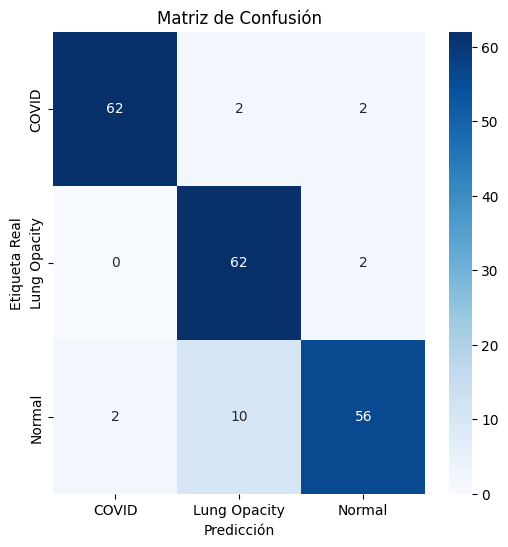

In [69]:
# ===================
# Matriz de Confusión
# ===================

# Inicializamos listas para almacenar predicciones y etiquetas reales
all_preds = []
all_labels = []

# Evaluar el modelo en el conjunto de validación
model_cargado.eval()  # Modo evaluación

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model_cargado(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print("Reporte de clasificación:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()


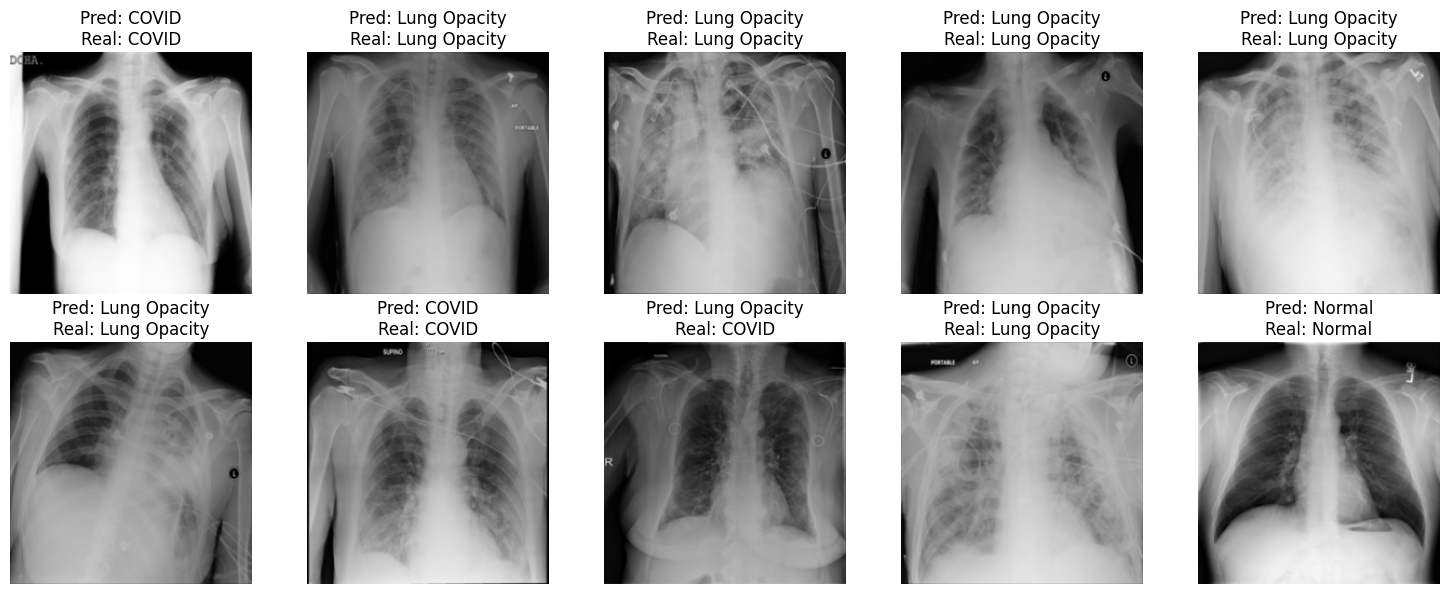

In [70]:
# =====================
# Pruebas de Predicción
# =====================

# Número de pruebas
num_tests = 10
indices = random.sample(range(len(val_dataset)), num_tests)

# Creamos una grilla (2x5)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
    # Se obtiene la imagen y su etiqueta real
    image, true_label = val_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)

    # Realizar la predicción sin cálculo de gradientes
    with torch.no_grad():
        output = model_cargado(input_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = predicted.item()
    true_class = true_label

    # Se desnormaliza la imagen para visualizarla correctamente
    img_np = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # Se muestra la imagen en el subplot correspondiente
    ax.imshow(img_np)
    ax.set_title(f"Pred: {classes[predicted_class]}\nReal: {classes[true_class]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Resultados de las predicciones:
Imagen: Normal-1000.png  |  Predicción: Normal


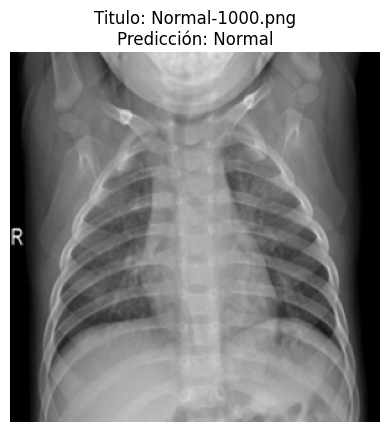

Imagen: COVID_1.png  |  Predicción: COVID


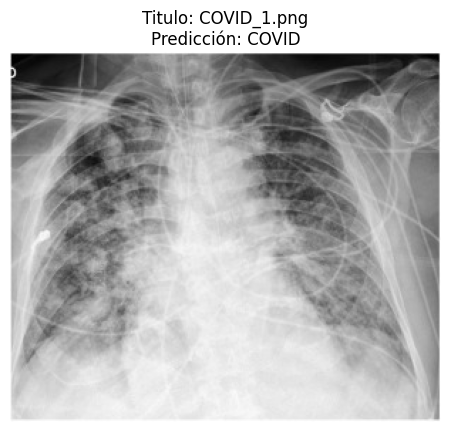

Imagen: COVID-1051.png  |  Predicción: COVID


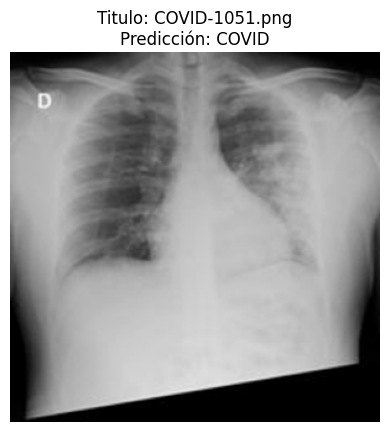

Imagen: Normal-10006.png  |  Predicción: Lung Opacity


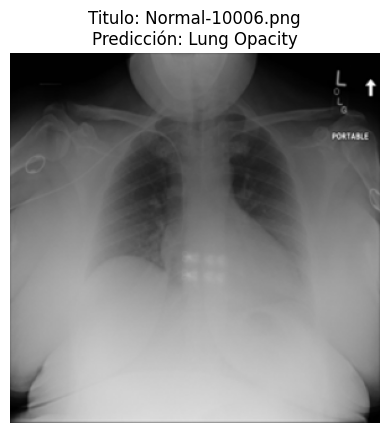

Imagen: Lung_Opacity-101.png  |  Predicción: Lung Opacity


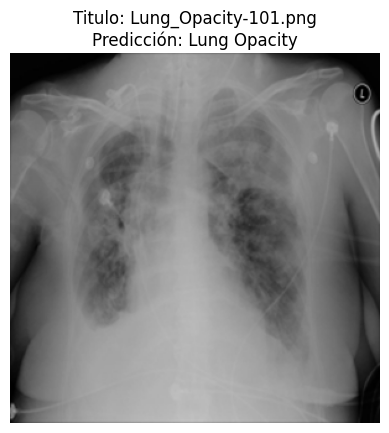

In [72]:
# ==============================
# Pruebas de con imagenes nuevas
# ==============================

# Se define la transformación que se usó para la validación
input_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Ruta a la carpeta que contiene las imágenes de entrada
#input_dir = 'Input'
input_dir = '/content/input'
# Se guardan todos los archivos PNG
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith('.png')]

if not image_files:
    print("No se encontraron imágenes PNG en la carpeta 'Input'.")
else:
    # Selecciona de manera aleatoria 10 imágenes.
    num_tests = min(10, len(image_files))
    sample_images = random.sample(image_files, num_tests)

    print("Resultados de las predicciones:")
    for image_filename in sample_images:
        image_path = os.path.join(input_dir, image_filename)

        # Se abre la imagen y se asegura de que esté en RGB
        image = Image.open(image_path).convert("RGB")

        # Se aplican las transformaciones
        image_tensor = input_transform(image)

        # Se agrega la dimensión de batch y mover al dispositivo
        image_tensor = image_tensor.unsqueeze(0).to(device)

        # Realizar la predicción sin calcular gradientes
        with torch.no_grad():
            output = model_cargado(image_tensor)
            _, predicted = torch.max(output, 1)

        predicted_class = predicted.item()

        # Imprimir el nombre del archivo y la categoría predicha
        print(f"Imagen: {image_filename}  |  Predicción: {classes[predicted_class]}")

        # Mostrar la imagen a modo de referencia
        plt.imshow(image)
        plt.title(f"Titulo: {image_filename}\nPredicción: {classes[predicted_class]}")
        plt.axis('off')
        plt.show()


In [ ]:
# =====================================================
# Se inicia modelo guardado en Netron para visualizarlo
# =====================================================
netron.start(f"modelo_scripted_{Version}.pt")

Serving 'modelo_scripted_V1.pt' at http://localhost:8080


('localhost', 8080)